In [ ]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
import inspect

In [ ]:
%pip install tiktoken

In [ ]:
dialogT=[]
emotionT=[]
dialogV=[]
emotionV=[]

for i in dataset['train']['dialog']:
    for s in i:
        dialogT.append(s+'\n')

for i in dataset['train']['emotion']:
    for e in i:
        emotionT.append(e)

for i in dataset['validation']['dialog']:
    for s in i:
        dialogV.append(s+'\n')

for i in dataset['validation']['emotion']:
    for e in i:
        emotionV.append(e)




In [ ]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")

train_ids=[]
train_emo_ids=[]
val_ids=[]
val_emo_ids=[]



for i in range(len(dialogT)):
    ec = enc.encode_ordinary(dialogT[i])
    l = len(ec)
    train_ids.extend(ec)
    train_emo_ids.extend([emotionT[i]]*l)

for i in range(len(dialogV)):
    ec = enc.encode_ordinary(dialogV[i])
    l = len(ec)
    val_ids.extend(ec)
    val_emo_ids.extend([emotionV[i]]*l)


print(len(train_ids))
print(train_emo_ids)
print(len(train_emo_ids))
print(train_ids)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import numpy as np
import os

data_dir = 'friends_gpt2'
os.makedirs(data_dir, exist_ok=True)

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(data_dir, 'train.bin'))
val_ids.tofile(os.path.join(data_dir, 'val.bin'))

train_emo_ids=np.array(train_emo_ids, dtype=np.uint16)
val_emo_ids = np.array(val_emo_ids, dtype=np.uint16)
train_emo_ids.tofile(os.path.join(data_dir, 'train_emo.bin'))
val_emo_ids.tofile(os.path.join(data_dir, 'val_emo.bin'))

# create a memory map
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

train_emo_data = np.memmap(os.path.join(data_dir, 'train_emo.bin'), dtype=np.uint16, mode='r')
val_emo_data = np.memmap(os.path.join(data_dir, 'val_emo.bin'), dtype=np.uint16, mode='r')


[0 0 0 ... 0 0 0]
[25515   837  5395 ...   764   220   198]


In [ ]:
import torch

def get_batch(data, emo, block_size, batch_size, device):
    """
    Return a minibatch of data. This function is not deterministic.
    Calling this function multiple times will result in multiple different
    return values.

    Parameters:
        `data` - a numpy array (e.g., created via a call to np.memmap)
        `block_size` - the length of each sequence
        `batch_size` - the number of sequences in the batch
        `device` - the device to place the returned PyTorch tensor

    Returns: A tuple of PyTorch tensors (x, t), where
        `x` - represents the input tokens, with shape (batch_size, block_size)
        `y` - represents the target output tokens, with shape (batch_size, block_size)
    """
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    e = torch.stack([torch.from_numpy((emo[i:i+block_size]).astype(np.int64)) for i in ix])
    t = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if 'cuda' in device:
        # pin arrays x,t, which allows us to move them to GPU asynchronously
        #  (non_blocking=True)
        x, t = x.pin_memory().to(device, non_blocking=True), t.pin_memory().to(device, non_blocking=True)
        e = e.pin_memory().to(device, non_blocking=True)
    else:
        x, t = x.to(device), t.to(device)
        e = e.to(device)
    return x, e, t


In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

In [ ]:
def enc_emo(emo):
    out = []
    for e in emo:
        if e == 'no emotion':
            out.append(0)
        if e == 'anger':
            out.append(1)
        if e == 'disgust':
            out.append(2)
        if e == 'fear':
            out.append(3)
        if e == "happiness":
            out.append(4)
        if e== "sadness":
            out.append(5)
        if e== "surprise":
            out.append(6)
    return out

def input_emo_encoder(s, txt_enc):
    s = [s]
    tmp = enc_emo(s)
    out = tmp*len(txt_enc)
    return (torch.tensor(out, dtype=torch.long, device=device)[None, ...])


def add_emo_helper(emo_idx):
    l=len(emo_idx[0])+1
    e = emo_idx[0,0]
    emotion=''
    if e == 0:
        emotion='no emotion'
    if e == 1:
        emotion='anger'
    if e == 2:
        emotion='disgust'
    if e == 3:
        emotion='fear'
    if e == 4:
        emotion='happiness'
    if e== 5:
        emotion='sadness'
    if e== 6:
        emotion='surprise'
    return input_emo_encoder(emotion, [1]*l)

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            wee = nn.Embedding(8, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, emo_idx,targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        #TODO
        emo_emb=self.transformer.wee(emo_idx)
        x = self.transformer.drop(tok_emb + pos_emb + emo_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        #assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, emo_idx,max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            if _==0:
                emo_cond=emo_idx
            if len(emo_cond[0]) < self.config.block_size and _!=0:

                emo_cond = add_emo_helper(emo_cond)
            else:
                emo_idx[:, -self.config.block_size:]

            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond, emo_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

In [ ]:
import easydict
import math
import time

finetune_config_dict = {
  'gradient_accumulation_steps': 32,
  'block_size': 256,
  'dropout': 0.2,
  'bias': False,
  'learning_rate': 3e-5,
  'weight_decay': 0.1,
  'beta1': 0.9,
  'beta2': 0.99,
  'grad_clip': 1.0,
  'decay_lr': False,
  'warmup_iters': 100,
  'lr_decay_iters': 5000,
  'min_lr': 0.0001}
config = easydict.EasyDict(finetune_config_dict)

In [ ]:
!pip install transformers

In [ ]:
# initialize from OpenAI GPT-2 weights
override_args = dict(dropout=config.dropout)
model = GPT.from_pretrained('gpt2', override_args)

# crop down the model block size using model surgery
if config.block_size < model.config.block_size:
    model.crop_block_size(config.block_size)

device = 'cuda' if torch.cuda.is_available()  else 'cpu'
model.to(device)

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.2
number of parameters: 123.66M


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (wee): Embedding(8, 768)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
import contextlib
# initialize a GradScaler. If enabled=False scaler is a no-op
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = contextlib.nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# learning rate decay scheduler (cosine with warmup)
def get_lr(config, it):
    # 1) linear warmup for warmup_iters steps
    if it < config.warmup_iters:
        return config.learning_rate * it / config.warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > config.lr_decay_iters:
        return config.min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - config.warmup_iters) / (config.lr_decay_iters - config.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return config.min_lr + coeff * (config.learning_rate - config.min_lr)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss(model, train_dataset, emo,val_dataset, block_size):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        dataset = train_dataset if split == 'train' else val_dataset
        for k in range(eval_iters):
            X, E, Y = get_batch(dataset, emo, block_size, batch_size, device)
            with ctx:
                logits, loss = model(X, E, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
import contextlib
# initialize a GradScaler. If enabled=False scaler is a no-op
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = contextlib.nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# learning rate decay scheduler (cosine with warmup)
def get_lr(config, it):
    # 1) linear warmup for warmup_iters steps
    if it < config.warmup_iters:
        return config.learning_rate * it / config.warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > config.lr_decay_iters:
        return config.min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - config.warmup_iters) / (config.lr_decay_iters - config.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return config.min_lr + coeff * (config.learning_rate - config.min_lr)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss(model, train_dataset, emo,val_dataset, block_size):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        dataset = train_dataset if split == 'train' else val_dataset
        for k in range(eval_iters):
            X, E, Y = get_batch(dataset, emo, block_size, batch_size, device)
            with ctx:
                logits, loss = model(X, E, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


num decayed parameter tensors: 51, with 123,734,784 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
step 0: train loss 3.2750, val loss 3.2594
iter 0: loss 4.5529, time 33264.29ms, mfu -100.00%
step 10: train loss 2.9487, val loss 2.9481
iter 10: loss 3.3746, time 33480.50ms, mfu 2.11%
step 20: train loss 2.8062, val loss 2.8047
iter 20: loss 3.1046, time 33493.26ms, mfu 2.11%
step 30: train loss 2.7352, val loss 2.7401
iter 30: loss 3.0904, time 33455.46ms, mfu 2.11%
step 40: train loss 2.6855, val loss 2.7048
iter 40: loss 2.9044, time 33513.05ms, mfu 2.11%
step 50: train loss 2.6628, val loss 2.6636
iter 50: loss 2.8909, time 33520.41ms, mfu 2.11%
step 60: train loss 2.6334, val loss 2.6651
iter 60: loss 2.8650, time 33542.73ms, mfu 2.11%
step 70: train loss 2.6133, val loss 2.6358
iter 70: loss 2.8025, time 33512.05ms, mfu 2.11%
step 80: train loss 2.5940, val loss 2.6036
iter 80: loss 2.8226, time 33565.12ms, mfu 2.11%
step 90: tra

RuntimeError: Parent directory C:/Users/c/Desktop does not exist.

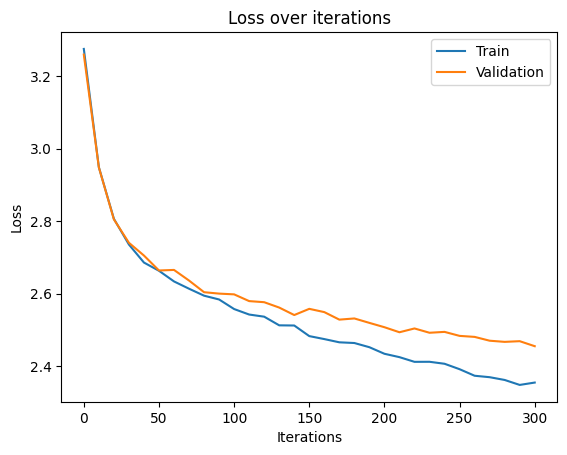

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import gc
gc.collect()
iter_num = 0
best_val_loss = 1e9
eval_interval = 10
log_interval = 10
eval_iters = 40
max_iters = 300
batch_size = 35

# optimizer
optimizer = model.configure_optimizers(config.weight_decay, config.learning_rate,
   (config.beta1, config.beta2), device)

# training loop
X, E, Y = get_batch(train_data, train_emo_data, config.block_size, batch_size, device) # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model # unwrap DDP container if needed
running_mfu = -1.0
try:
    iters, train_loss, val_loss= [], [], []
    while True:
        # determine and set the learning rate for this iteration
        lr = get_lr(config, iter_num) if config.decay_lr else config.learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # evaluate the loss on train/val sets and write checkpoints
        if iter_num % eval_interval == 0:
            losses = estimate_loss(model, train_data, train_emo_data, val_data, config.block_size)
            iters.append(iter_num)
            train_loss.append(losses['train'])
            val_loss.append(losses['val'])
            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # forward backward update, with optional gradient accumulation to simulate larger batch size
        # and using the GradScaler if data type is float16
        for micro_step in range(config.gradient_accumulation_steps):
            with ctx:
                logits, loss = model(X, E, Y)
                loss = loss / config.gradient_accumulation_steps # scale the loss to account for gradient accumulation
            # immediately async prefetch next batch while model is doing the forward pass on the GPU
            X, E, Y = get_batch(train_data, train_emo_data, config.block_size, batch_size, device)
            # backward pass, with gradient scaling if training in fp16
            scaler.scale(loss).backward()

        # clip the gradient
        if config.grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

        # step the optimizer and scaler if training in fp16
        scaler.step(optimizer)
        scaler.update()

        # flush the gradients as soon as we can, no need for this memory anymore
        optimizer.zero_grad(set_to_none=True)

        # timing and logging
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        if iter_num % log_interval == 0:
            # get loss as float. note: this is a CPU-GPU sync point
            # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
            lossf = loss.item() * config.gradient_accumulation_steps
            if local_iter_num >= 5: # let the training loop settle a bit
                mfu = raw_model.estimate_mfu(batch_size * config.gradient_accumulation_steps, dt)
                running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
            print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")

        iter_num += 1
        local_iter_num += 1

        # termination conditions
        if iter_num > max_iters:
            break

finally:
    plt.figure()
    plt.plot(iters[:len(train_loss)], train_loss)
    plt.plot(iters[:len(val_loss)], val_loss)
    plt.title("Loss over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])


model.eval()
torch.save(copy.deepcopy(model.state_dict()), "/content/drive/MyDrive/chatbot2.pth")

In [ ]:
torch.save(copy.deepcopy(model.state_dict()), "/content/drive/MyDrive/chatbot2.pth")

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/chatbot2.pth"))
model.eval()
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
start_emo='happiness'
num_samples = 1 # number of samples to draw
max_new_tokens = 100 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability


enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

start_ids = encode(start)

x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
e = input_emo_encoder(start_emo,start_ids)




#model = finetuned_model
# run generation

with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, e, max_new_tokens, temperature=temperature, top_k=top_k)
            out = decode(y[0].tolist())
            print(out)




 Yes . I feel very sad about this.Our wedding is to be held on October 24th , so I have to prepare my things . 
 We promise to arrange a reception for December 30th.Will you please come and have a look ? 
 I will . There are so many people I could not attend . 
 Why are you so nervous ? 
 I am afraid that the weather is kind to us . I have a fever . 
 What can I do for you


In [ ]:
test_sentences = [
    "I'm so mad right now ! \n",
    'This makes me angry . \n',
    "I'm fuming ! \n",
    'Why am I always so angry ? \n',
    "I'm outraged ! \n",
    "That's gross ! \n",
    "I'm disgusted . \n",
    "Ew ,  that's nasty ! \n",
    'This is repulsive . \n',
    "I can't stand this . \n",
    "I'm scared . \n",
    'This is terrifying . \n',
    'I feel afraid . \n',
    "I'm really frightened . \n",
    'This is spooky . \n',
    "I'm so happy ! \n",
    'This is awesome ! \n',
    "I'm delighted . \n",
    "Yay ,  I'm so glad ! \n",
    'This makes me smile . \n',
    "I'm feeling sad . \n",  # Sadness
    "This is so upsetting . \n",  # Sadness
    "I'm really down . \n",  # Sadness
    "Why am I so sad ? \n",  # Sadness
    "This makes me gloomy . \n",  # Sadness
    "Wow ,  that's surprising ! \n",  # Surprise
    "I didn't expect this . \n",  # Surprise
    "This is shocking ! \n",  # Surprise
    "Really ?  That's unexpected . \n",  # Surprise
    "I'm amazed by this ! \n"   # Surprise
]
test_emo = [
    "anger",       # For sentences 1-5
    "anger",
    "anger",
    "anger",
    "anger",
    "disgust",     # For sentences 6-10
    "disgust",
    "disgust",
    "disgust",
    "disgust",
    "fear",        # For sentences 11-15
    "fear",
    "fear",
    "fear",
    "fear",
    "happiness",   # For sentences 16-20
    "happiness",
    "happiness",
    "happiness",
    "happiness",
    "sadness",     # For sentences 21-25
    "sadness",
    "sadness",
    "sadness",
    "sadness",
    "surprise",   # For sentences 26-30
    "surprise",
    "surprise",
    "surprise",
    "surprise"
]

out = []
for i in range(len(test_sentences)):
    start_ids = encode(test_sentences[i])
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    e = input_emo_encoder(test_emo[i],start_ids)
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y = model.generate(x, e, max_new_tokens, temperature=temperature, top_k=top_k)
                out.append(decode(y[0].tolist()))

outt = []
for i in out:
    outt.append(i.split("\n")[1:-1])

print(outt)



[[' How dare you do that . ', ' Oh , dear ! What have you done to that ? ', " No , it's nothing . ", " Oh , dear , it's nothing ! ", " Thank you.You'll have a delicious meal later . ", " I'll go . ", "You're welcome . See you in a week . ", ' No problem . ', 'Excuse me . I am looking for my passport . ', ' Could you show me your passport please ? '], [" If it wasn't for you , I wouldn't tell you . ", " You've got to go . ", "Have you heard about America's unemployment problem ? ", ' Yes , it has been steadily rising for many years . ', " I've heard that Americans have a high rate of unemployment . ", ' What does it mean ? ', ' The American dream is to have a job and have a family , but unemployment is not the only responsibility that comes with it . ', ' Really ? '], [' What ? But I have a baby . ', ' My mind is on it . ', ' How can you say that ? ', " You don't know what you're talking about . I know I've been out of work since 7 , and I ’ m getting laid off.So you're going crazy ? ",

In [ ]:
for item in outt:
  print(item)

[' How dare you do that . ', ' Oh , dear ! What have you done to that ? ', " No , it's nothing . ", " Oh , dear , it's nothing ! ", " Thank you.You'll have a delicious meal later . ", " I'll go . ", "You're welcome . See you in a week . ", ' No problem . ', 'Excuse me . I am looking for my passport . ', ' Could you show me your passport please ? ']
[" If it wasn't for you , I wouldn't tell you . ", " You've got to go . ", "Have you heard about America's unemployment problem ? ", ' Yes , it has been steadily rising for many years . ', " I've heard that Americans have a high rate of unemployment . ", ' What does it mean ? ', ' The American dream is to have a job and have a family , but unemployment is not the only responsibility that comes with it . ', ' Really ? ']
[' What ? But I have a baby . ', ' My mind is on it . ', ' How can you say that ? ', " You don't know what you're talking about . I know I've been out of work since 7 , and I ’ m getting laid off.So you're going crazy ? ", " 

In [ ]:
for item in out:
  print(item)

I'm so mad right now ! 
 How dare you do that . 
 Oh , dear ! What have you done to that ? 
 No , it's nothing . 
 Oh , dear , it's nothing ! 
 Thank you.You'll have a delicious meal later . 
 I'll go . 
You're welcome . See you in a week . 
 No problem . 
Excuse me . I am looking for my passport . 
 Could you show me your passport please ? 
 Sorry.
This makes me angry . 
 If it wasn't for you , I wouldn't tell you . 
 You've got to go . 
Have you heard about America's unemployment problem ? 
 Yes , it has been steadily rising for many years . 
 I've heard that Americans have a high rate of unemployment . 
 What does it mean ? 
 The American dream is to have a job and have a family , but unemployment is not the only responsibility that comes with it . 
 Really ? 
 I
I'm fuming ! 
 What ? But I have a baby . 
 My mind is on it . 
 How can you say that ? 
 You don't know what you're talking about . I know I've been out of work since 7 , and I ’ m getting laid off.So you're going crazy ? 